#  Compute the Fair Price of a Zero Coupon Treasury Bill

## Background
T-Bills are financial instruments with short-term due dates ranging from a few days to 52 weeks. They are fixed-income investments with zero coupons, meaning no coupon payments are made during the term. Instead, the price of treasury bills is calculated so that the bill receiver gets the face (par) value ($V_{P}$) at the end of the term. 

### Pricing
A zero-coupon T-bill with an annual effective market interest rate $\bar{r}$, which is specified at the time of purchase, and a term of T years has a _fair price_ of:

$$
V_{B} = \frac{V_{P}}{\left(1+\bar{r}\right)^{T}}
$$

T-bills are released for specific periods such as 4, 8, 13, 26, and 52 weeks. The fair price ($V_{B}$) of the T-bill is the future face value ($V_{P}$) that is discounted to today’s value by the effective market interest rate ($\bar{r}$). When the treasury bill is purchased, the effective annual interest rate $\bar{r}$ equals the T-bill yield. However, if the treasury bill is resold, these values will be different.

## Objectives
Let's compute the fair price of 4-week and 52-week treasury bills using historical yield data gathered daily from 2019 to 2023. In addition, we'll explore the term structure of the interest rates, i.e., calculate the [short rates](https://en.wikipedia.org/wiki/Short-rate_model) and the [yield to maturity (YTM)](https://en.wikipedia.org/wiki/Yield_to_maturity) of a 52-week treasury bill  using a [binomial lattice model](http://www.columbia.edu/~mh2078/FoundationsFE/lattice_models.pdf). 

### Tasks and Strategies
1. Using the quoted annualized effective market interest rate $\bar{r}$, show that the fair price of a 52-week T-bill is more sensitive to changes in $\bar{r}$ than a 4-week T-bill with the same face (par) value.
1. Using a binomial lattice model calibrated from historical data, compute the price of a 52-week T-bill and the yield to maturity (YTM) by computing the expected short rates.

## Setup
In the following code blocks we setup the computational aspects of the problem by including the `Include.jl` file. The `Include.jl` file loads external packages, functions that we will use in this excercise and custom types to model the components of our problem.

#### Packages
`Include.jl` loads several external packages that we will use for our excercise:
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) provides a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it a great general purpose data science tool.

#### Functions
`Include.jl` loads the [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

* The `loadratesfile(year::String = "2022") -> DataFrame` function takes a [String](https://docs.julialang.org/en/v1/manual/strings/) encoding the year in the `YYYY` format, e.g., `"2019"` or `"2020"` and returns a [DataFrame](https://dataframes.juliadata.org/stable/) holding the daily interest rates for US Treasury Bills for various durations found on [Treasury.gov](https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_bill_rates). This project has data from `"2019"`, `"2020"`, `"2021"`, `"2022"` and `"2022"`. The year parameter has a default value of `"2022"`.
* The `build(model::Type{MyUSTreasuryBillModel}, data::NamedTuple) -> MyUSTreasuryBillModel` function takes information in the `data` arguement (the par value, the rate and the duration of the T-bill) and returns an instance of the `MyUSTreasuryBillModel` custom type.

#### Types
`Include.jl` loads some [problem specific types](https://docs.julialang.org/en/v1/manual/functions/) that will be helpful for the analysis of T-bill pricing. 

* `MyUSTreasuryBillModel` is a [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types) holding the par value $V_{P}$, the duration $T$ and the interest rate $\bar{r}$ for a zero-coupon treasury bill. You construct a `MyUSTreasuryBillModel` instance using the `build` method described above.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-131/module-1`


#### Load historical interest rate data sets

In [16]:
rate_data_dictionary = Dict{String,DataFrame}();
years = ["2019","2020","2021","2022","2023"];
for year ∈ years
    rate_data_dictionary[year] = loadratesfile(year=year);
end

## Compute $V_{B}$ for a 4-week and 52-week T-bill

#### Set constant values
* `selected_year` is a `String` that holds a value for the year we are interested in, e.g., `"2022"`. 
* $V_{P}$ is a `Float64` that holds the face (par) value of the treasury bill in USD (future value paid at the maturity of the treasury bill).
* `number_of_days` is an `Int` that holds the number of days of data we have for a given year.
* `number_of_weeks_per_year` is an `Int` that holds the number of weeks in a year, we set this to `52`.

In [17]:
selected_year = "2022"
rate_data = rate_data_dictionary[selected_year];
number_of_days = nrow(rate_data);
number_of_weeks_per_year = 52;
Vₚ = 100.0;

#### Compute the fair price $V_{B}$ of 4-week T-bill

In [4]:
T = (4.0/number_of_weeks_per_year);

prices_4_weeks = Array{Float64,2}(undef, number_of_days, 3)
counter = 1;
for i ∈ number_of_days:-1:1
    
    # get the market interest rate from the data set 
    r̄ = rate_data[i,Symbol("4 WEEKS BANK DISCOUNT")]*(1/100);
    
    # compute the discount rate
    𝒟 = (1+r̄)^T;
    
    # compute the prices array
    prices_4_weeks[counter,1] = counter;
    prices_4_weeks[counter,2] = r̄;
    prices_4_weeks[counter,3] = (1/𝒟)*Vₚ
    
    # update the counter
    counter += 1
end

#### Compute the fair price $V_{B}$ of 52-week T-bill

In [5]:
T = (52.0/number_of_weeks_per_year);

number_of_days = nrow(rate_data);
prices_52_weeks = Array{Float64,2}(undef, number_of_days, 3)
counter = 1;
for i ∈ number_of_days:-1:1
    
    # get the market interest rate from the data set 
    r̄ = rate_data[i,Symbol("52 WEEKS BANK DISCOUNT")]*(1/100);
    
    # compute the discount rate
    𝒟 = (1+r̄)^T;
    
    # compute the prices array
    prices_52_weeks[counter,1] = counter;
    prices_52_weeks[counter,2] = r̄;
    prices_52_weeks[counter,3] = (1/𝒟)*Vₚ
    
     # update the counter
    counter += 1
end

#### Visualize the fair price $V_{B}$ as a function of the market interest rate

##### Case: The 4-week T-bill price $V_{B}$ versus the market interest rate $\bar{r}$:

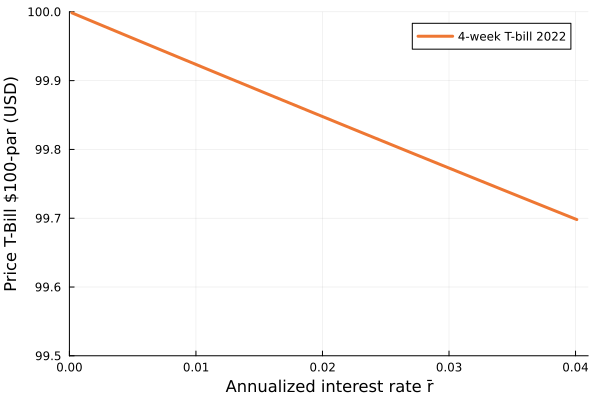

In [6]:
idx = sortperm(prices_4_weeks[:,2]);
plot(prices_4_weeks[idx,2], prices_4_weeks[idx,3],lw=3,c=colors[1],xlim=(0.0,0.041), 
    ylim=(99.5,100.0), label="4-week T-bill $(selected_year)", xlabel="Annualized interest rate r̄", 
    ylabel="Price T-Bill \$100-par (USD)")

##### Case: The 52-week T-bill price $V_{B}$ versus the market interest rate $\bar{r}$:

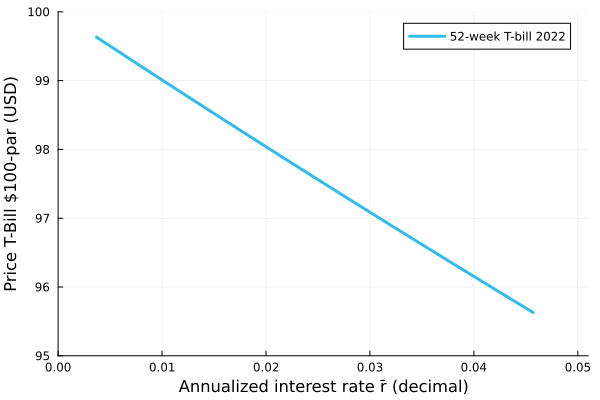

In [7]:
idx = sortperm(prices_52_weeks[:,2]);
plot(prices_52_weeks[idx,2], prices_52_weeks[idx,3],lw=3,c=colors[3], 
    xlim=(0.0,0.051), ylim=(95.0,100.0),label="52-week T-bill $(selected_year)", 
    xlabel="Annualized interest rate r̄ (decimal)", ylabel="Price T-Bill \$100-par (USD)")

## Task 2: Binomial lattice model prediction of 52-Week T-bill pricing

### Estimate the probability of an `up` move
If we have a year’s worth of daily data (around 252 samples), we can determine how many times the interest rate increased between consecutive days by calculating the occurrences of $r_{j+1}>r_{j}$ in the data.

In [8]:
# initialize -
number_of_days = nrow(rate_data);
counter = 0;
key = Symbol("52 WEEKS BANK DISCOUNT");

for i ∈ 2:number_of_days
    
    # remember: data is newest to oldest
    r_today = rate_data[i-1,key];
    r_yesterday = rate_data[i,key];
    
    if (r_today > r_yesterday)
        counter += 1
    end
end

# compute p (sorry Bayesian people ...)
p = counter/number_of_days;

# println -
println("In $(selected_year), the probability of a daily increase in rates was p = $(p)")

In 2022, the probability of a daily increase in rates was p = 0.5502008032128514


### Estimate the expected magnitude of an `up` move

In [9]:
# initialize -
number_of_days = nrow(rate_data);
up_move_array = Array{Float64,1}();

for i ∈ 2:number_of_days
    
    # remember: data is newest to oldest
    r_today = rate_data[i-1,key];
    r_yesterday = rate_data[i,key];
    
    if (r_today > r_yesterday)
        u = r_today/r_yesterday;
        push!(up_move_array, u);
    end
end

# compute the average
ū = mean(up_move_array)

# print -
println("The mean magnitude of an up move is ū = $(ū)")

The mean magnitude of an up move is ū = 1.0326128653393791


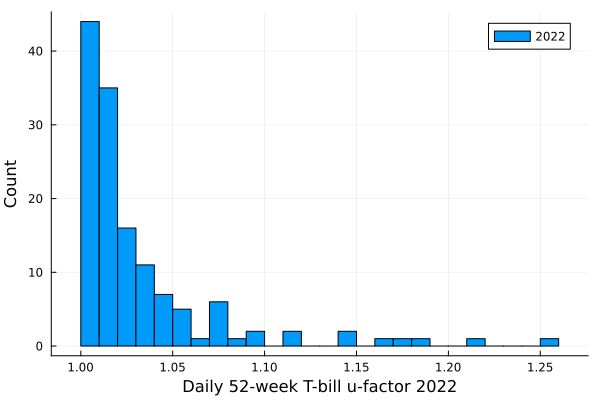

In [10]:
histogram(up_move_array, xlabel="Daily 52-week T-bill u-factor $(selected_year)", 
    ylabel="Count", label="2022")

### Estimate the expected magnitude of a `down` move

In [11]:
# initialize -
number_of_days = nrow(rate_data);
down_move_array = Array{Float64,1}();

for i ∈ 2:number_of_days
    
    # remember: data is newest to oldest
    r_today = rate_data[i-1,key];
    r_yesterday = rate_data[i,key];
    
    if (r_today < r_yesterday)
        d = r_today/r_yesterday;
        push!(down_move_array, d);
    end
end

# compute the average of the down moves
d̄ = mean(down_move_array);

# print -
println("The mean magnitude of a down move is d̄ = $(d̄)")

The mean magnitude of a down move is d̄ = 0.9802363511251919


### Predict the future T-bill price using a Binomial lattice model

#### Check: Binomial lattice T-bill price
Comparing the T-bill price predicted by the lattice model with the price calculated using the quoted initial interest rate $\bar{r}$ is possible. To obtain this initial interest rate, we need to convert the rate quoted for the first business day in January to a decimal:

In [12]:
r̄ = rate_data[end, key]*(1/100);

We then compute the fair price $V_{B}$ of a 52-week T-bill for $V_{P}=1000$ USD using $\bar{r}$:

In [13]:
VB = Vₚ*(1/(1+r̄));

Finally, using the lattice model, we predict the price of the 52-week T-Bill by assuming daily compounding business day:

In [14]:
T = number_of_days; 
rₒ = 0.265*rate_data[end, key]*(1/100)*(1/T);

model = build(MySymmetricBinaryLatticeModel,(
    u = ū, d = d̄, p = p, rₒ = rₒ, T = T,
)) |> populate |> (model -> solve(model, Vₚ = Vₚ));

VBLM = model.data[0].price;

##### Summary table

In [15]:
summary_table_header = (["Item", "Value"]);
summary_table_data = Array{Any,2}(undef, 3,2);
summary_table_data[1,1] = "Fair price (USD)"
summary_table_data[1,2] = VB;
summary_table_data[2,1] = "Lattice model price (USD)"
summary_table_data[2,2] = VBLM;
summary_table_data[3,1] = "Difference (%)"
summary_table_data[3,2] = (abs(VBLM-VB)/VB)*100;

# show the table -
pretty_table(summary_table_data, header=summary_table_header)

┌───────────────────────────┬────────────┐
│                      Item │      Value │
├───────────────────────────┼────────────┤
│          Fair price (USD) │    99.6115 │
│ Lattice model price (USD) │    99.6142 │
│            Difference (%) │ 0.00268893 │
└───────────────────────────┴────────────┘
